## ***Seattle Birdcall Classification using Neural Networks***
##### Submitted by ~ *Mahek Patel*



### Introduction
This project applies deep learning techniques to classify bird species based on their unique sounds. Using spectrograms derived from bird call audio clips collected in the Seattle area, we will explore how convolutional neural networks (CNNs) can effectively recognize auditory patterns. The task simulates a real-world scenario in ecological monitoring and species identification.

In [110]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import random
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import Input
from sklearn.utils import class_weight
import IPython.display as ipd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [112]:
# Loading spectogram data
h5_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\bird_spectrograms.hdf5"
f = h5py.File(h5_path, 'r')
species_keys = list(f.keys())

# Loading trainging data
txt_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\train_extended.txt"
train_meta = pd.read_csv(txt_path)

# Loading the test MP3 files
test_dir = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_birds"
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.mp3')])

test_data = []
for file in test_files:
    file_path = os.path.join(test_dir, file)
    audio, sr = librosa.load(file_path, sr=22050)
    test_data.append((file, audio, sr))

## Data Exploration

#### 1. Exploring 'bird_spectrograms.hdf5'

In [7]:
# HDF5 training exploration 
print("Bird names:")
for i, key in enumerate(species_keys):
    print(f"{i+1}. {key}")

print("\nBirds overview:")
for key in species_keys:
    shape = f[key].shape  
    print(f"{key}: {shape[2]} samples (shape: {shape})")

Bird names:
1. amecro
2. amerob
3. bewwre
4. bkcchi
5. daejun
6. houfin
7. houspa
8. norfli
9. rewbla
10. sonspa
11. spotow
12. whcspa

Birds overview:
amecro: 66 samples (shape: (128, 517, 66))
amerob: 172 samples (shape: (128, 517, 172))
bewwre: 144 samples (shape: (128, 517, 144))
bkcchi: 45 samples (shape: (128, 517, 45))
daejun: 125 samples (shape: (128, 517, 125))
houfin: 84 samples (shape: (128, 517, 84))
houspa: 630 samples (shape: (128, 517, 630))
norfli: 37 samples (shape: (128, 517, 37))
rewbla: 187 samples (shape: (128, 517, 187))
sonspa: 263 samples (shape: (128, 517, 263))
spotow: 137 samples (shape: (128, 517, 137))
whcspa: 91 samples (shape: (128, 517, 91))


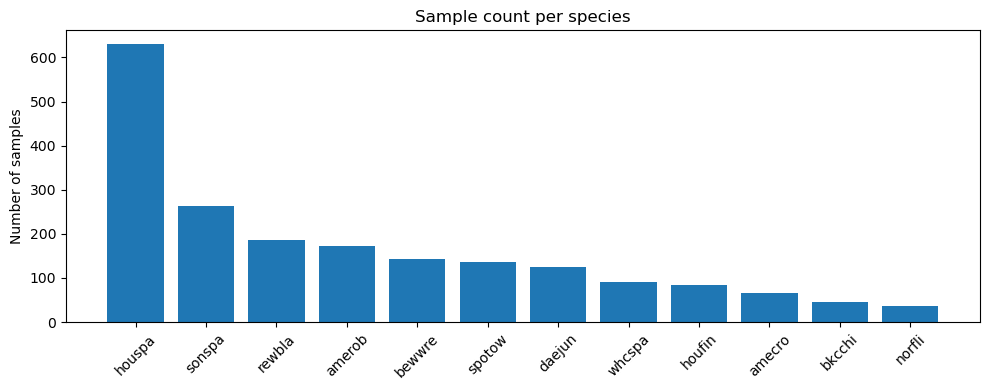

In [8]:
# Distribution of species 
species_counts = {key: f[key].shape[2] for key in species_keys}
sorted_counts = dict(sorted(species_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=45)
plt.title("Sample count per species")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

Plot comments:
- 'houspa' has over 630 samples, dominating the dataset.

- Species like norfli, bkcchi, and amecro have fewer than 50 samples.

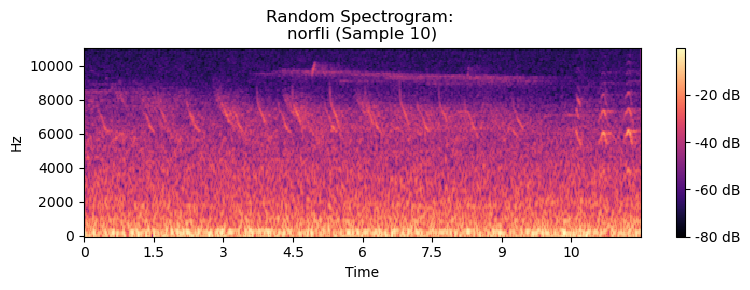

In [10]:
# Spectogram (for any random species)
def random_training():
    species_key = random.choice(species_keys)
    
    # Total number of samples for that species
    num_samples = f[species_key].shape[2]

    # Selectiing index
    index = random.randint(0, num_samples - 1)
    
    spec = f[species_key][:, :, index]
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(spec, sr=22050, hop_length=512, x_axis='time', y_axis='linear')
    plt.title(f"Random Spectrogram: \n{species_key} (Sample {index})")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

random_training()

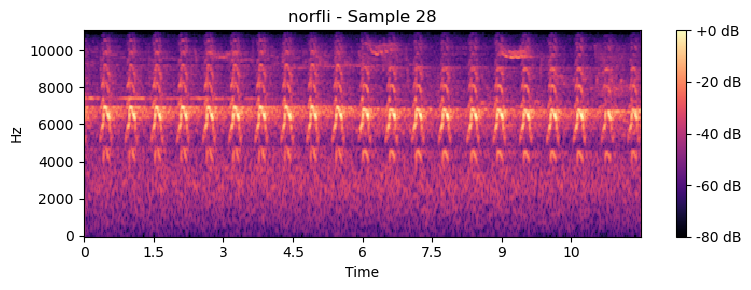

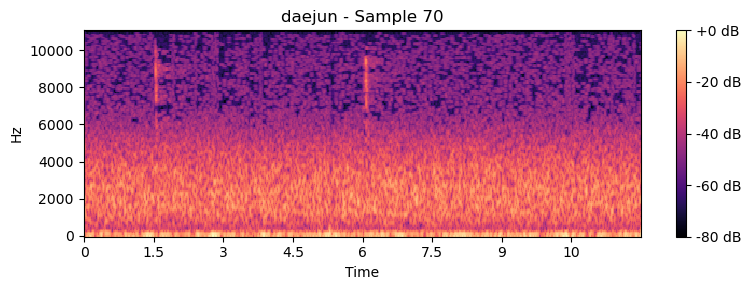

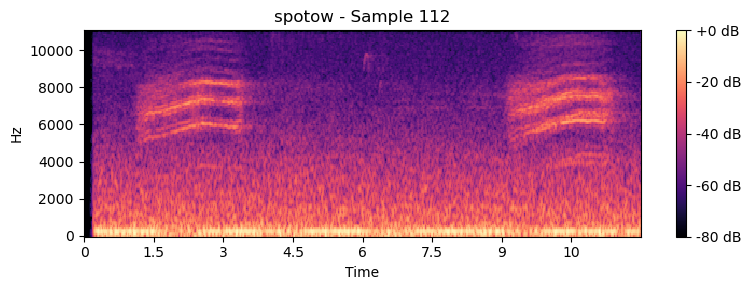

In [11]:
# Comparing any 3 random species
def random_spect(n_species=3):
    selected_species = random.sample(species_keys, n_species)

    for species in selected_species:
        index = random.randint(0, f[species].shape[2] - 1)
        spec = f[species][:, :, index]
        plt.figure(figsize=(8, 3))
        librosa.display.specshow(spec, sr=22050, hop_length=512, x_axis='time', y_axis='linear')
        plt.title(f"{species} - Sample {index}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

random_spect(3)

#### 2. Exploring the test audio files

In [13]:
# Duration and testing rates of test (audio) files
print("\nTest Audio File Summary:")
for file, audio, sr in test_data:
    duration = len(audio) / sr
    print(f"{file}: duration = {duration:.2f} sec, sampling rate = {sr}")


Test Audio File Summary:
test1.mp3: duration = 23.28 sec, sampling rate = 22050
test2.mp3: duration = 5.25 sec, sampling rate = 22050
test3.mp3: duration = 15.88 sec, sampling rate = 22050


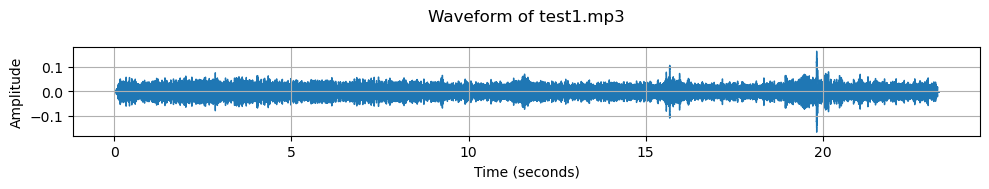

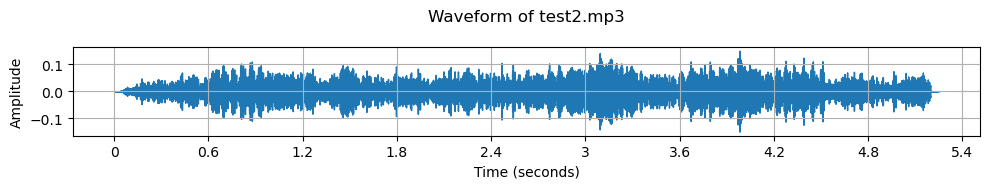

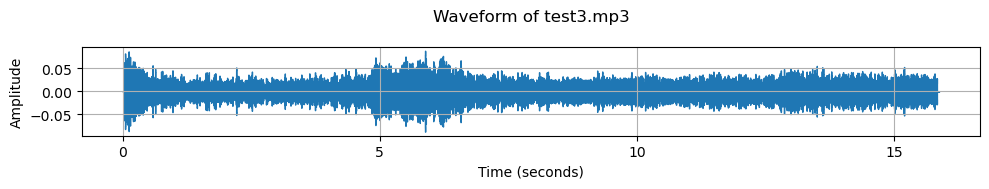

In [14]:
# Waveforms for all the test files
def all_test():
    for file, audio, sr in test_data:
        plt.figure(figsize=(10, 2))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform of {file}\n")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
all_test()

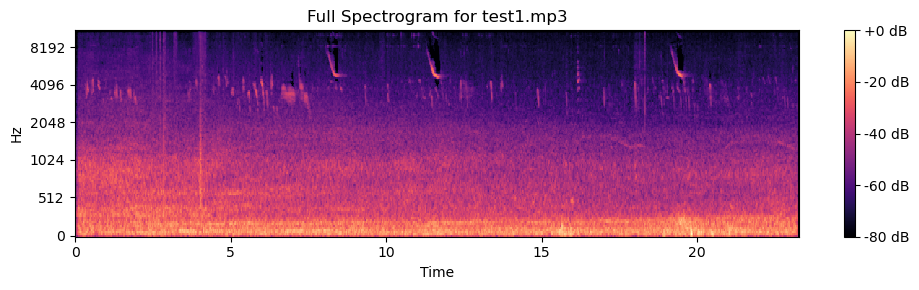

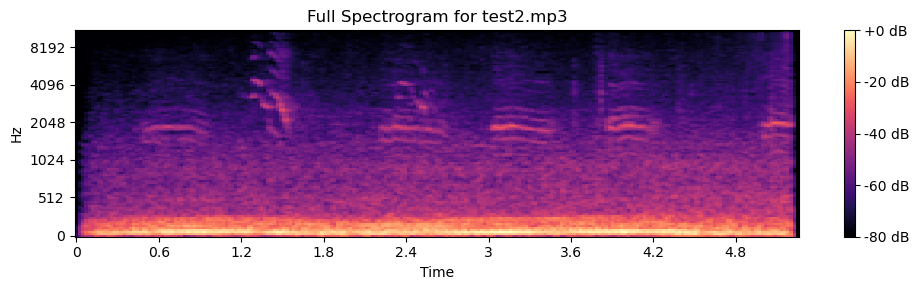

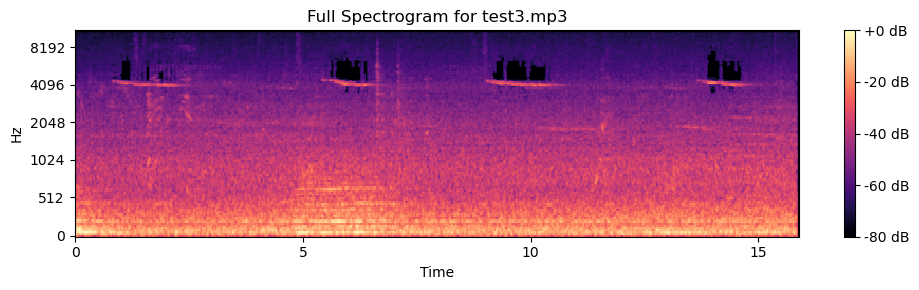

In [15]:
# Spectograms for test files
def all_test_spect(test_data):
    for file, audio, sr in test_data:
        # Generating mel-scaled spectrogram from full audio
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(10, 3))
        librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Full Spectrogram for {file}")
        plt.tight_layout()
        plt.show()
all_test_spect(test_data)

Did this to visually explore the frequency content of each clip over its full duration and to understand where bird calls may occur. This might be further useful for discussion, analysis, hypothesis building and also find out if there's more than one bird species in it.

In [17]:
# Playing the test files

def play_test():
    for i, (file, audio, sr) in enumerate(test_data):
        print(f"\nPlaying Clip {i+1}: \n{file} | Duration: {len(audio)/sr:.2f} sec\n")
        display(ipd.Audio(audio, rate=sr))

play_test()


Playing Clip 1: 
test1.mp3 | Duration: 23.28 sec




Playing Clip 2: 
test2.mp3 | Duration: 5.25 sec




Playing Clip 3: 
test3.mp3 | Duration: 15.88 sec



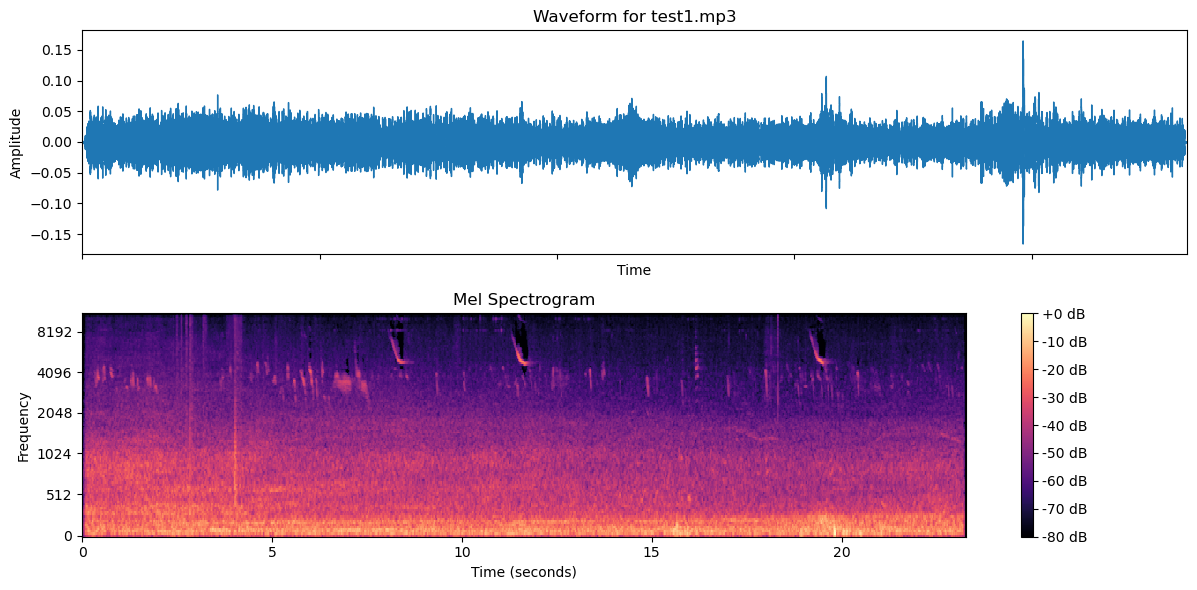

In [18]:
# Waveform + Spectrogram plot [OPTIONAL!]
def combined_test():
    # Randomly select a test clip
    file, audio, sr = random.choice(test_data)

    # Creating a mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plotting waveform and spectrogram in one frame
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=ax[0])
    ax[0].set_title(f"Waveform for {file}")
    ax[0].set_ylabel("Amplitude")

    # Spectrogram
    img = librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set_title("Mel Spectrogram")
    ax[1].set_ylabel("Frequency")
    fig.colorbar(img, ax=ax[1], format="%+2.0f dB")

    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

combined_test()

# Kept it random to explore different clips

Performed this to visually correlate loudness spikes with frequency changes. Also helps to easily identify bird call regions in a test sample all at the same time.

#### 3. Exploring the metadata

In [21]:
# Exploring metadata
print("Metadata Shape:", train_meta.shape)
print("\nFirst few rows:")
train_meta.head()

Metadata Shape: (23784, 29)

First few rows:


rating playback_used ebird_code    channels        date  duration  \
0     0.0            no     aldfly  2 (stereo)  2019-06-11        49   
1     0.0            no     aldfly  2 (stereo)  2020-04-14        21   
2     0.0           yes     aldfly  2 (stereo)  2020-04-05        35   
3     0.0           yes     aldfly  2 (stereo)  2020-04-05        12   
4     0.0           yes     aldfly  2 (stereo)  2020-04-05        38   

       filename           species  \
0  XC554809.mp3  Alder Flycatcher   
1  XC552408.mp3  Alder Flycatcher   
2  XC544552.mp3  Alder Flycatcher   
3  XC544551.mp3  Alder Flycatcher   
4  XC544550.mp3  Alder Flycatcher   

                                           title secondary_labels  ...  \
0  XC554809 Alder Flycatcher (Empidonax alnorum)               []  ...   
1  XC552408 Alder Flycatcher (Empidonax alnorum)               []  ...   
2  XC544552 Alder Flycatcher (Empidonax alnorum)               []  ...   
3  XC544551 Alder Flycatcher (Empidonax alnorum)               []  ...   
4  XC544550 Alder Flycatcher (Empidonax alnorum)               []  ...   

  background   xc_id                                url        country  \
0        NaN  554809  https://www.xeno-canto.org/554809  United States   
1        NaN  552408  https://www.xeno-canto.org/552408       Colombia   
2        NaN  544552  https://www.xeno-canto.org/544552       Colombia   
3        NaN  544551  https://www.xeno-canto.org/544551       Colombia   
4        NaN  544550  https://www.xeno-canto.org/544550       Colombia   

           author                       primary_label longitude   time  \
0   Ron Overholtz  Empidonax alnorum_Alder Flycatcher -149.9757  07:00   
1  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  17:00   
2  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
3  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
4  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   

        recordist                                            license  
0   Ron Overholtz  Creative Commons Attribution-NonCommercial-Sha...  
1  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
2  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
3  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
4  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 29 columns]

In [22]:
# Overview of columns and data types
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784 entries, 0 to 23783
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            23784 non-null  float64
 1   playback_used     21938 non-null  object 
 2   ebird_code        23784 non-null  object 
 3   channels          23784 non-null  object 
 4   date              23784 non-null  object 
 5   duration          23784 non-null  int64  
 6   filename          23784 non-null  object 
 7   species           23784 non-null  object 
 8   title             23784 non-null  object 
 9   secondary_labels  23784 non-null  object 
 10  bird_seen         21827 non-null  object 
 11  sci_name          23784 non-null  object 
 12  location          23784 non-null  object 
 13  latitude          23359 non-null  float64
 14  sampling_rate     23784 non-null  object 
 15  type              23755 non-null  object 
 16  elevation         23784 non-null  object

In [23]:
# Checking for missing values
print("Missing values per column:")
print(train_meta.isnull().sum())

Missing values per column:
rating                  0
playback_used        1846
ebird_code              0
channels                0
date                    0
duration                0
filename                0
species                 0
title                   0
secondary_labels        0
bird_seen            1957
sci_name                0
location                0
latitude              425
sampling_rate           0
type                   29
elevation               0
bitrate_of_mp3          0
file_type               0
background          12766
xc_id                   0
url                     0
country                 0
author                  0
primary_label           0
longitude             425
time                    0
recordist               0
license                 0
dtype: int64


In [24]:
# Unique values in important columns
print("Unique species:", train_meta['ebird_code'].nunique())
print("Species list:", train_meta['ebird_code'].unique())

print("\nUnique ratings:", train_meta['rating'].unique())
print("Sampling rates used:", train_meta['sampling_rate'].unique())

Unique species: 259
Species list: ['aldfly' 'ameavo' 'amebit' 'amecro' 'amegfi' 'amekes' 'amepip' 'amered'
 'amerob' 'amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag'
 'balori' 'banswa' 'barswa' 'bawwar' 'belkin1' 'belspa2' 'bewwre' 'bkbcuc'
 'bkbmag1' 'bkbwar' 'bkcchi' 'bkchum' 'bkhgro' 'bkpwar' 'bktspa' 'blkpho'
 'blugrb1' 'blujay' 'bnhcow' 'boboli' 'bongul' 'brdowl' 'brebla' 'brespa'
 'brncre' 'brnthr' 'brthum' 'brwhaw' 'btbwar' 'btnwar' 'btywar' 'buffle'
 'buggna' 'buhvir' 'bulori' 'bushti' 'buwwar' 'cacwre' 'calgul' 'calqua'
 'camwar' 'cangoo' 'canwar' 'canwre' 'carwre' 'casfin' 'caster1' 'casvir'
 'cedwax' 'chispa' 'chiswi' 'chswar' 'chukar' 'clanut' 'cliswa' 'comgol'
 'comgra' 'comloo' 'commer' 'comnig' 'comrav' 'comred' 'comter' 'comyel'
 'coohaw' 'coshum' 'cowscj1' 'daejun' 'dowwoo' 'dusfly' 'eargre' 'easblu'
 'easkin' 'easmea' 'easpho' 'eastow' 'eawpew' 'eucdov' 'eursta' 'evegro'
 'fiespa' 'fiscro' 'foxspa' 'gadwal' 'gnttow' 'gnwtea' 'gockin' 'gocspa'
 'goleag' '

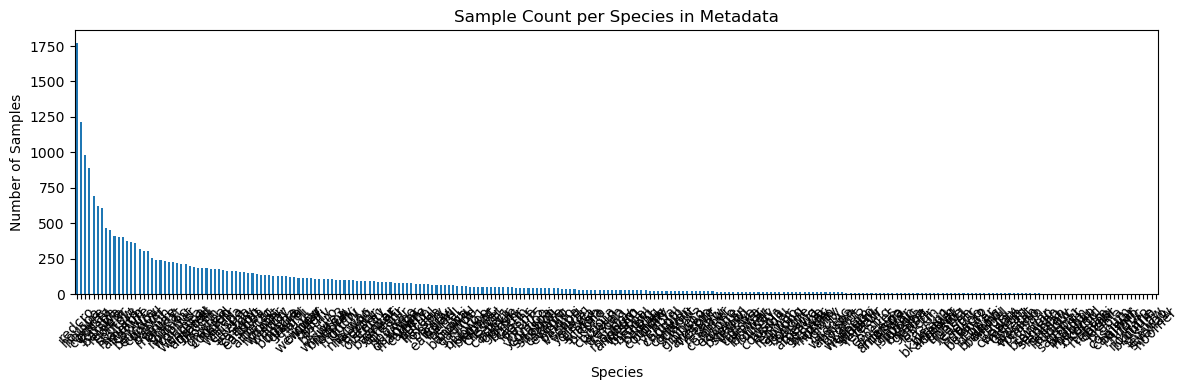

In [25]:
# Class distribution for the full dataset (OPTIONAL!)
species_counts = train_meta['ebird_code'].value_counts()

plt.figure(figsize=(12, 4))
species_counts.plot(kind='bar')
plt.title("Sample Count per Species in Metadata")
plt.xlabel("Species")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

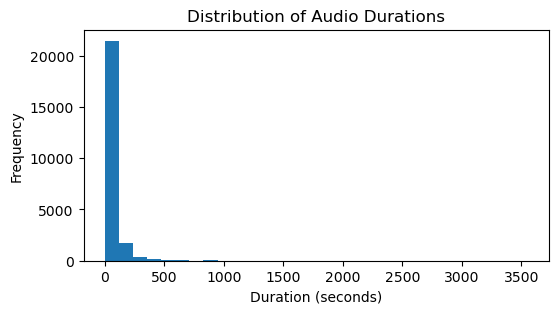

In [26]:
# Audio distribution (OPTIONAL!)
train_meta['duration'].plot(kind='hist', bins=30, figsize=(6, 3), title='Distribution of Audio Durations')
plt.xlabel("Duration (seconds)")
plt.show()

### Data Cleaning

In [28]:
# Keeping only the 12 important species used in spectrogram data
meta_clean = train_meta[train_meta['ebird_code'].isin(species_keys)]

# Removing recordings with other birds (clean secondary_labels)
meta_clean = meta_clean[meta_clean['secondary_labels'] == '[]']

# Filtering based on quality and length
meta_clean = meta_clean[
    (meta_clean['rating'] >= 3.0) &
    (meta_clean['duration'] >= 3.0) &
    (meta_clean['sampling_rate'].isin(['44100 (Hz)', '48000 (Hz)']))
]

# Dropping unnecessary and empty columns
meta_clean = meta_clean.drop(columns=['playback_used', 'bird_seen', 'background'])

# Dropping rows with missing values
meta_clean = meta_clean.dropna()

# Final shape 
print("\nFinal cleaned metadata shape:", meta_clean.shape)
meta_clean.head()


Final cleaned metadata shape: (1956, 26)


rating ebird_code    channels        date  duration      filename  \
166     5.0     amecro  2 (stereo)  2020-07-12        44  XC575220.mp3   
169     5.0     amecro  2 (stereo)  2020-06-17        41  XC569711.mp3   
171     5.0     amecro    1 (mono)  2020-06-14        78  XC568365.mp3   
173     5.0     amecro  2 (stereo)  0000-00-00        52  XC561291.mp3   
174     5.0     amecro    1 (mono)  2019-04-18        13  XC556240.mp3   

           species                                              title  \
166  American Crow     XC575220 American Crow (Corvus brachyrhynchos)   
169  American Crow  XC569711 American Crow (Corvus brachyrhynchos ...   
171  American Crow  XC568365 American Crow (Corvus brachyrhynchos ...   
173  American Crow     XC561291 American Crow (Corvus brachyrhynchos)   
174  American Crow     XC556240 American Crow (Corvus brachyrhynchos)   

    secondary_labels               sci_name  ... file_type   xc_id  \
166               []  Corvus brachyrhynchos  ...       mp3  575220   
169               []  Corvus brachyrhynchos  ...       mp3  569711   
171               []  Corvus brachyrhynchos  ...       mp3  568365   
173               []  Corvus brachyrhynchos  ...       mp3  561291   
174               []  Corvus brachyrhynchos  ...       mp3  556240   

                                   url        country          author  \
166  https://www.xeno-canto.org/575220  United States  Michael Hurben   
169  https://www.xeno-canto.org/569711  United States       Russ Wigh   
171  https://www.xeno-canto.org/568365  United States       Russ Wigh   
173  https://www.xeno-canto.org/561291  United States       Jim Berry   
174  https://www.xeno-canto.org/556240  United States      Caio Brito   

                           primary_label longitude   time       recordist  \
166  Corvus brachyrhynchos_American Crow -93.37860  06:00  Michael Hurben   
169  Corvus brachyrhynchos_American Crow -81.05590  15:00       Russ Wigh   
171  Corvus brachyrhynchos_American Crow -81.05590  07:00       Russ Wigh   
173  Corvus brachyrhynchos_American Crow -79.23810  06:00       Jim Berry   
174  Corvus brachyrhynchos_American Crow -81.40509  18:35      Caio Brito   

                                               license  
166  Creative Commons Attribution-NonCommercial-Sha...  
169  Creative Commons Attribution-NonCommercial-Sha...  
171  Creative Commons Attribution-NonCommercial-Sha...  
173  Creative Commons Attribution-NonCommercial-Sha...  
174  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 26 columns]

### Model Preparation

### 1. Binary Classification

In [31]:
# Selecting random species for binary classification

bin_species = [key for key in species_keys if f[key].shape[2] >= 50]
species_1, species_2 = random.sample(bin_species, 2)
print(f"\nSelected species for binary classification: {species_1} vs {species_2}")


Selected species for binary classification: amerob vs bewwre


In [32]:
X1 = np.transpose(f[species_1][:], (2, 0, 1))
X2 = np.transpose(f[species_2][:], (2, 0, 1))
y1 = np.zeros(X1.shape[0])
y2 = np.ones(X2.shape[0])

X_binary = np.concatenate((X1, X2), axis=0)
y_binary = np.concatenate((y1, y2), axis=0)

print(f"\n{species_1} samples: {X1.shape[0]}, {species_2} samples: {X2.shape[0]}")
print(f"Combined dataset shape: X = {X_binary.shape}, y = {y_binary.shape}")


amerob samples: 172, bewwre samples: 144
Combined dataset shape: X = (316, 128, 517), y = (316,)


In [33]:
# Splitting the dataset int train/test

# Shuffling the dataset
X_binary, y_binary = shuffle(X_binary, y_binary, random_state=42)

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (221, 128, 517) (221,)
Testing set shape: (95, 128, 517) (95,)


In [34]:
# Normalising the spectogram data (better for training nueral networks)

def normalize(x, eps=1e-8):
    min_val = np.min(x)
    max_val = np.max(x)
    range_val = max_val - min_val
    if range_val < eps:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - min_val) / (range_val + eps)).astype(np.float32)

# Scaled the data to avoid any consequences and for better processing

X_train_norm = np.array([normalize(x) for x in X_train], dtype=np.float32)
X_test_norm = np.array([normalize(x) for x in X_test], dtype=np.float32)

print("Normalized Train (min/max):", X_train_norm.min(), ",", X_train_norm.max())
print("Normalized Test (min/max):", X_test_norm.min(), ",", X_test_norm.max())

Normalized Train (min/max): 0.0 , 1.0
Normalized Test (min/max): 0.0 , 1.0


In [35]:
# Reshaping for CNN (samples, height, width, channels)
X_train_cnn = X_train_norm[..., np.newaxis]  # shape: (N, 128, 517, 1)
X_test_cnn = X_test_norm[..., np.newaxis]

# Model building
model = Sequential([
    Input(shape=(128, 517, 1)),                     
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model training
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=16,
                    validation_data=(X_test_cnn, y_test))

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.4778 - loss: 2.3210 - val_accuracy: 0.5474 - val_loss: 0.6861
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.6012 - loss: 0.7047 - val_accuracy: 0.4632 - val_loss: 0.6930
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.5554 - loss: 0.6921 - val_accuracy: 0.4526 - val_loss: 0.6930
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6326 - loss: 0.6879 - val_accuracy: 0.5474 - val_loss: 0.6927
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.6407 - loss: 0.6829 - val_accuracy: 0.5474 - val_loss: 0.6921
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.6084 - loss: 0.6747 - val_accuracy: 0.5474 - val_loss: 0.6869
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5458 - loss: 0.6833 - val_accuracy: 0.6632 - val_loss: 0.6815
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.6126 - loss: 0.6756 - val_accuracy: 0.

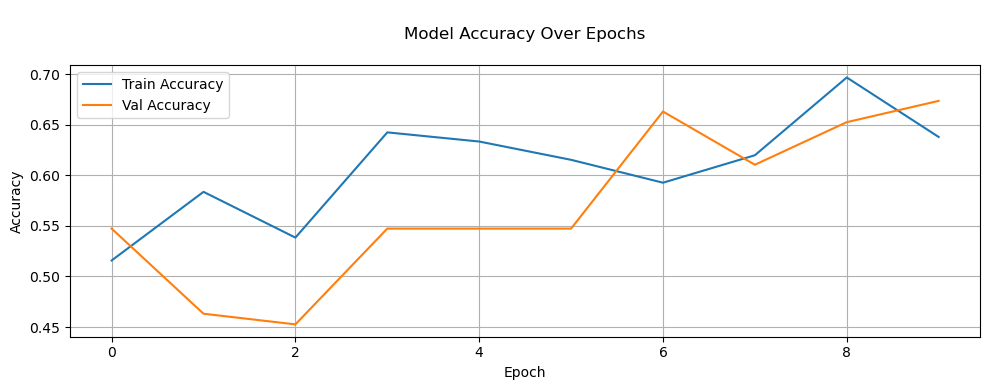

In [36]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('\nModel Accuracy Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

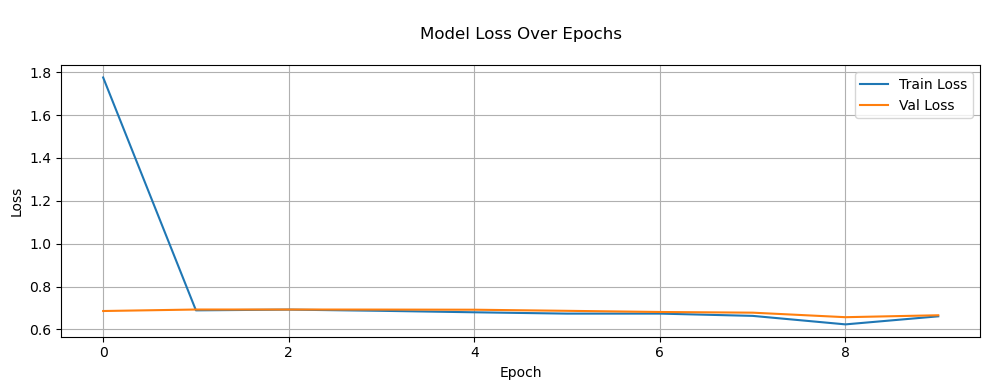

In [37]:
# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('\nModel Loss Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Summary for model performance
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc:.4f}", f"{final_train_loss:.4f}"],
    'Validation': [f"{final_val_acc:.4f}", f"{final_val_loss:.4f}"]
})

summary_df

Metric Training Validation
0  Accuracy   0.6380     0.6737
1      Loss   0.6613     0.6662

In [39]:
# Predictions and thresholds at 0.5
y_pred_prob = model.predict(X_test_cnn)

# Converting probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


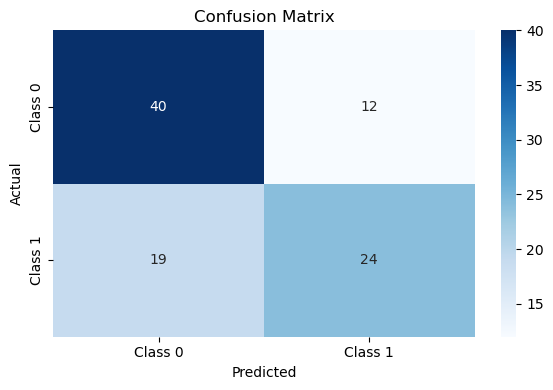


Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72        52
         1.0       0.67      0.56      0.61        43

    accuracy                           0.67        95
   macro avg       0.67      0.66      0.66        95
weighted avg       0.67      0.67      0.67        95



In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### 2. Multi-Class Classification

In [42]:
X_multi = []
y_multi = []
label_map = {}

# Looping through all the 12 species
for i, species in enumerate(species_keys):
    # Load and convert to float32 immediately
    spectrograms = f[species][:].astype(np.float32)  
    num_samples = spectrograms.shape[2]

    for j in range(num_samples):
        X_multi.append(spectrograms[:, :, j])  
        y_multi.append(i)

    label_map[species] = i

# Converting lists to numpy arrays
X_multi = np.array(X_multi, dtype=np.float32)
y_multi = np.array(y_multi)

print("X_multi shape:", X_multi.shape)
print("y_multi shape:", y_multi.shape)
print("\nLabel mapping:", label_map)

X_multi shape: (1981, 128, 517)
y_multi shape: (1981,)

Label mapping: {'amecro': 0, 'amerob': 1, 'bewwre': 2, 'bkcchi': 3, 'daejun': 4, 'houfin': 5, 'houspa': 6, 'norfli': 7, 'rewbla': 8, 'sonspa': 9, 'spotow': 10, 'whcspa': 11}


In [43]:
# Splitting the dataset int train/test

# Shuffling the dataset
X_multi, y_multi = shuffle(X_multi, y_multi, random_state=42)

# Train-test split (70/30)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)

# Normalizing each spectrogram sample to [0, 1]
epsilon = 1e-8  # constant to prevent divide-by-zero

X_train_m_norm = np.array([
    (x - np.min(x)) / (np.max(x) - np.min(x) + epsilon) for x in X_train_m])

X_test_m_norm = np.array([
    (x - np.min(x)) / (np.max(x) - np.min(x) + epsilon) for x in X_test_m])

# Reshaping for CNN input
X_train_m_cnn = X_train_m_norm[..., np.newaxis]
X_test_m_cnn = X_test_m_norm[..., np.newaxis]

print("Training set shape:", X_train_m_cnn.shape)
print("Testing set shape:", X_test_m_cnn.shape)

Training set shape: (1386, 128, 517, 1)
Testing set shape: (595, 128, 517, 1)


In [153]:
# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_m),
    y=y_train_m
)
class_weights = dict(enumerate(class_weights)) 

# Building the CNN model
multi_model = Sequential([
    Input(shape=(128, 517, 1)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(12, activation='softmax')])

# Model compilation
multi_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_multi = multi_model.fit(
    X_train_m_cnn, y_train_m,
    validation_data=(X_test_m_cnn, y_test_m),
    epochs=30,
    batch_size=32,
    class_weight=class_weights)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.1076 - loss: 34.6144 - val_accuracy: 0.0639 - val_loss: 83.3095
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.0414 - loss: 2.7091 - val_accuracy: 0.0639 - val_loss: 90.2701
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.0438 - loss: 2.5421 - val_accuracy: 0.0639 - val_loss: 63.4762
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.0451 - loss: 2.4532 - val_accuracy: 0.0639 - val_loss: 45.0074
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.0407 - loss: 2.3881 - val_accuracy: 0.0639 - val_loss: 35.1442
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.0416 - loss: 2.5614 - val_accuracy: 0.0639 - val_loss: 31.0747
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.0499 - loss: 2.4659 - val_accuracy: 0.0639 - val_loss: 27.4087
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.0515 - loss: 2.4650 - val_accuracy: 0.

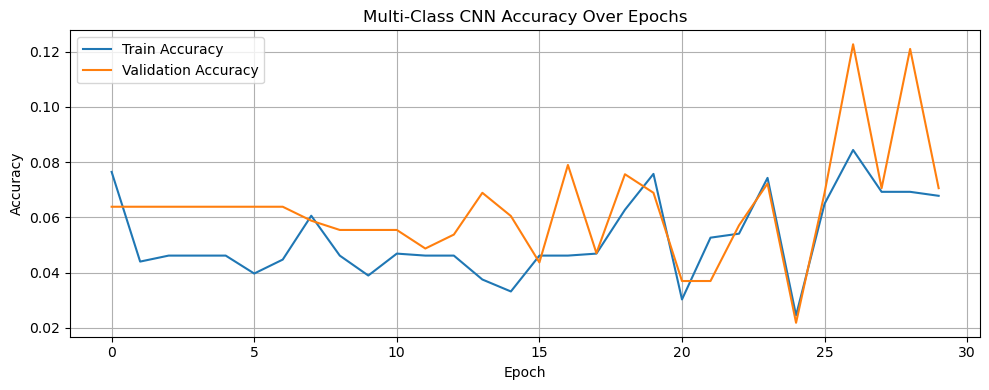

In [155]:
# Accuracy plot

plt.figure(figsize=(10, 4))
plt.plot(history_multi.history['accuracy'], label='Train Accuracy')
plt.plot(history_multi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

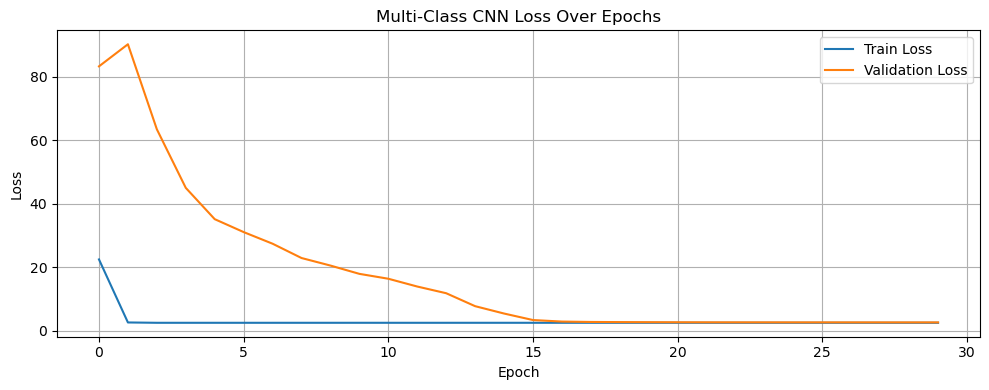

In [157]:
# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history_multi.history['loss'], label='Train Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
# Summary for model performance
final_train_acc = history_multi.history['accuracy'][-1]
final_val_acc = history_multi.history['val_accuracy'][-1]
final_train_loss = history_multi.history['loss'][-1]
final_val_loss = history_multi.history['val_loss'][-1]

summary_multi_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc:.4f}", f"{final_train_loss:.4f}"],
    'Validation': [f"{final_val_acc:.4f}", f"{final_val_loss:.4f}"]
})

summary_multi_df

Metric Training Validation
0  Accuracy   0.0678     0.0706
1      Loss   2.4851     2.6111

In [161]:
# Predicting class probabilities
y_pred_probs = multi_model.predict(X_test_m_cnn)

# Convert to class labels (index of max prob)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step


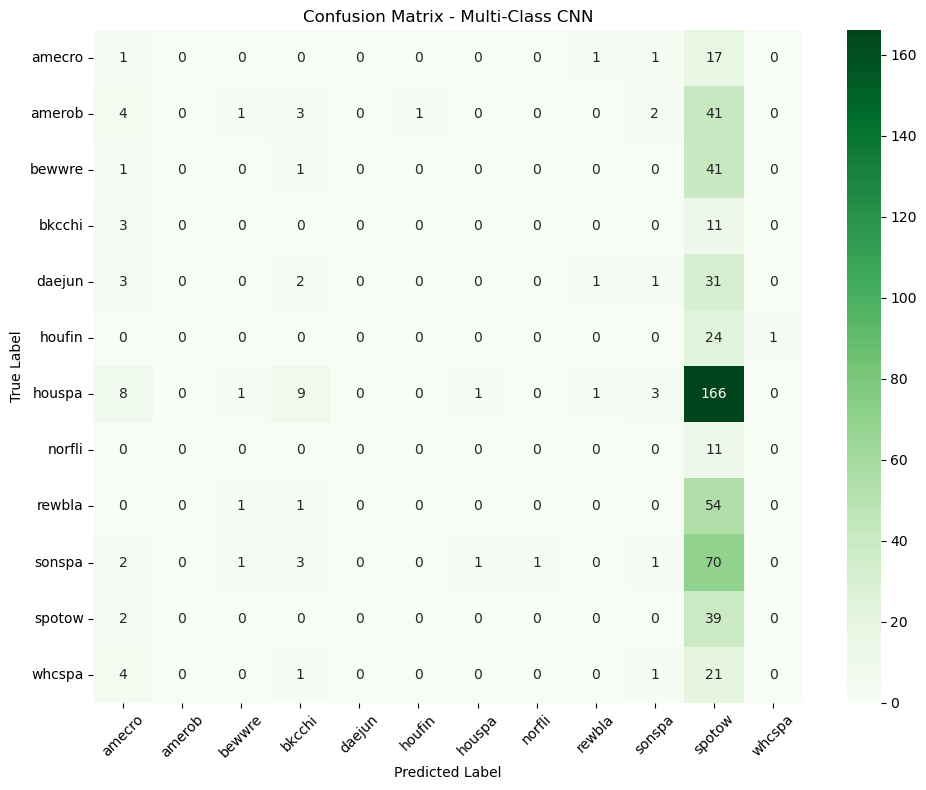

Classification Report:

              precision    recall  f1-score   support

      amecro       0.04      0.05      0.04        20
      amerob       0.00      0.00      0.00        52
      bewwre       0.00      0.00      0.00        43
      bkcchi       0.00      0.00      0.00        14
      daejun       0.00      0.00      0.00        38
      houfin       0.00      0.00      0.00        25
      houspa       0.50      0.01      0.01       189
      norfli       0.00      0.00      0.00        11
      rewbla       0.00      0.00      0.00        56
      sonspa       0.11      0.01      0.02        79
      spotow       0.07      0.95      0.14        41
      whcspa       0.00      0.00      0.00        27

    accuracy                           0.07       595
   macro avg       0.06      0.08      0.02       595
weighted avg       0.18      0.07      0.02       595



In [163]:
# Confusion Matrix
cm = confusion_matrix(y_test_m, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multi-Class CNN')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test_m, y_pred_classes, target_names=label_map.keys(),zero_division=0 ))

# Used zero_division=0 to avoid division-by-zero warnings

#### Converting test files to spectograms

Mel spectrogram shape: (128, 517) 



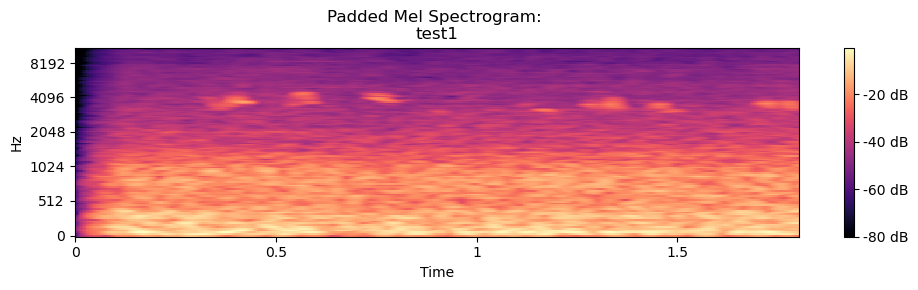

In [166]:
# Test1

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test1_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest1")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec1 = mel_spec                 # Later used for normalisation

Mel spectrogram shape: (128, 517) 



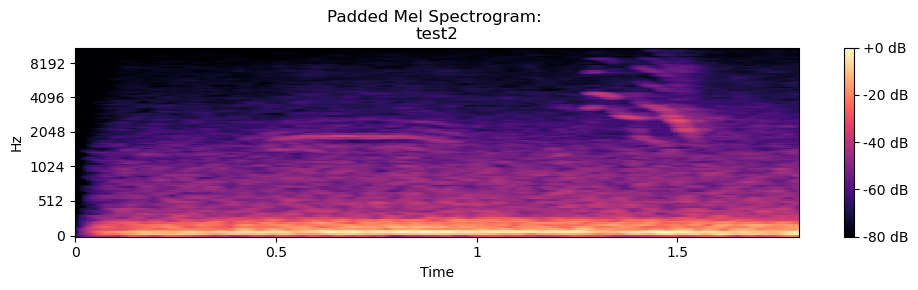

In [168]:
# Test2

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test2_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest2")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec2 = mel_spec                 # Later used for normalisation

Mel spectrogram shape: (128, 517) 



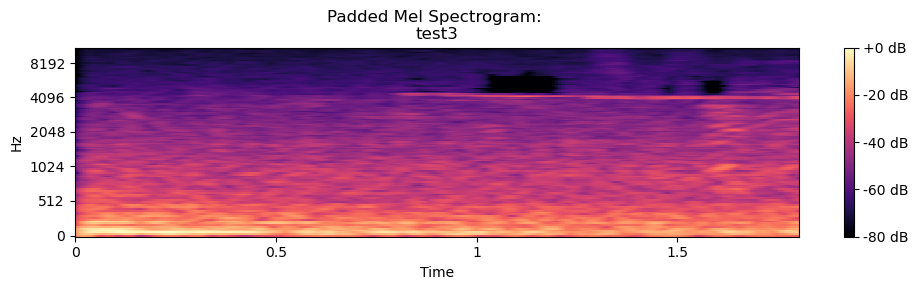

In [170]:
# Test3

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test3_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest3")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec3 = mel_spec                 # Later used for normalisation

In [172]:
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        return np.pad(spec, ((0, 0), (0, target_width - current_width)), mode='constant')
    elif current_width > target_width:
        return spec[:, :target_width]
    return spec
spec1 = pad_spectrogram(spec1)
spec2 = pad_spectrogram(spec2)
spec3 = pad_spectrogram(spec3)

In [174]:
# Normalizing all 3 spectrograms
spec1_norm = (spec1 - np.min(spec1)) / (np.max(spec1) - np.min(spec1) + 1e-8)
spec2_norm = (spec2 - np.min(spec2)) / (np.max(spec2) - np.min(spec2) + 1e-8)
spec3_norm = (spec3 - np.min(spec3)) / (np.max(spec3) - np.min(spec3) + 1e-8)

# Adding channel dimensions
spec1_input = spec1_norm[..., np.newaxis]
spec2_input = spec2_norm[..., np.newaxis]
spec3_input = spec3_norm[..., np.newaxis]

# Combining all 3 together
X_test_final = np.array([spec1_input, spec2_input, spec3_input])
print("Final input shape for prediction:", X_test_final.shape)

Final input shape for prediction: (3, 128, 517, 1)


In [176]:
# Class probabilities
pred_probs = multi_model.predict(X_test_final)

# Class indices
predicted_indices = np.argmax(pred_probs, axis=1)

# Mapping indices back to their species names
index_to_species = {v: k for k, v in label_map.items()}
predicted_species = [index_to_species[idx] for idx in predicted_indices]

for i, species in enumerate(predicted_species, 1):
    print(f"Test clip {i}: Predicted species = {species}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Test clip 1: Predicted species = norfli
Test clip 2: Predicted species = norfli
Test clip 3: Predicted species = norfli


In [178]:
import pandas as pd

# Create final result table
result_df = pd.DataFrame({
    "Test Clip": ["test1_audio", "test2_audio", "test3_audio"],
    "Predicted Species": predicted_species
})

# Display table
result_df

Test Clip Predicted Species
0  test1_audio            norfli
1  test2_audio            norfli
2  test3_audio            norfli

In [180]:
# Get species names from label map
index_to_species = {v: k for k, v in label_map.items()}

# Top 3 predictions per clip
top3_results = []

for probs in pred_probs:
    top_indices = np.argsort(probs)[::-1][:3]
    top_species = [(index_to_species[i], round(probs[i], 3)) for i in top_indices]
    top3_results.append(top_species)

In [182]:
# Prepare data for table
data = {
    "Test Clip": ["test1_audio", "test2_audio", "test3_audio"],
    "Top Prediction": [f"{s[0][0]} ({s[0][1]})" for s in top3_results],
    "Top 2 Prediction": [f"{s[1][0]} ({s[1][1]})" for s in top3_results],
    "Top 3 Prediction": [f"{s[2][0]} ({s[2][1]})" for s in top3_results],
}

df_top3 = pd.DataFrame(data)
df_top3

Test Clip                Top Prediction              Top 2 Prediction  \
0  test1_audio  norfli (0.25999999046325684)  amerob (0.14000000059604645)   
1  test2_audio   norfli (0.1589999943971634)  amerob (0.11800000071525574)   
2  test3_audio   norfli (0.2240000069141388)  amerob (0.13500000536441803)   

               Top 3 Prediction  
0  whcspa (0.12600000202655792)  
1   whcspa (0.1120000034570694)  
2  whcspa (0.12300000339746475)

Conclusion:

- This project was about learning to recognize the unique voices of birds through audio clips. By turning bird calls into mel spectrograms (a visual representations of sound), we trained neural networks to classify 12 different bird species commonly found around Seattle. After experimenting with both binary and multi-class models, we fine-tuned our approach to handle challenges like imbalanced data using class weighting and ensured consistent input formatting through careful normalization. In the final step, we tested our model on real bird call recordings, allowing the network to actually listen to the bird sounds and make its best guess. 
- While the results weren’t perfect, the model showed promising signs of learning the subtle patterns that make each bird’s call special, bringing us one step closer to teaching machines how to accurately recognise the sounds of nature.